In [1]:
import pandas as pd
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
import matplotlib

C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Importing Data

In [3]:
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [4]:
TRAIN = "UCI HAR Dataset\\UCI HAR Dataset\\train\\"
TEST = "UCI HAR Dataset\\UCI HAR Dataset\\test\\"

# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

In [5]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = TRAIN + "y_train.txt"
y_test_path = TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [10]:
print('X_train len', len(X_train))
print('y_train len', len(y_train))
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)

X_train len 7352
y_train len 7352
X_train shape (7352, 128, 9)
y_train shape (7352, 1)


In [11]:
xtrain_df = pd.DataFrame(X_train.reshape(len(X_train),1152))
ytrain_df = pd.DataFrame(y_train.reshape(len(y_train),1))
xtest_df = pd.DataFrame(X_test.reshape(len(X_test),1152))
ytest_df = pd.DataFrame(y_test.reshape(len(y_test),1))

In [12]:
xtrain_df.shape
ytrain_df.shape

(7352, 1)

In [14]:
#feature561_df = pd.read_csv('UCI HAR Dataset\\UCI HAR Dataset\\features.txt',header= None, sep='\s+')
subjectTrain_df = pd.read_csv('UCI HAR Dataset\\UCI HAR Dataset\\train\\subject_train.txt',header= None, sep='\s+')

In [15]:
#import pandas as pd
#import numpy as np
#xtrain_df = pd.read_csv('C:\\Users\\prith\\Downloads\\UCI HAR Dataset\\UCI HAR Dataset\\train\\X_train.txt',header= None, sep='\s+')

#ytrain_df = pd.read_csv('C:\\Users\\prith\\Downloads\\UCI HAR Dataset\\UCI HAR Dataset\\train\\Y_train.txt',header= None, sep='\s+')
#xtest_df = pd.read_csv('C:\\Users\\prith\\Downloads\\UCI HAR Dataset\\UCI HAR Dataset\\test\\X_test.txt',header= None, sep='\s+')
#ytest_df = pd.read_csv('C:\\Users\\prith\\Downloads\\UCI HAR Dataset\\UCI HAR Dataset\\test\\Y_test.txt',header= None, sep='\s+')


# Exploratory Data Analysis

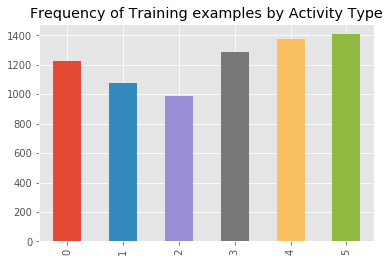

In [16]:
#Plotting the frequency of training data by activity type
import matplotlib.pyplot as plt
plt.show(ytrain_df[0].value_counts().sort_index().plot(kind='bar', title='Frequency of Training examples by Activity Type'))

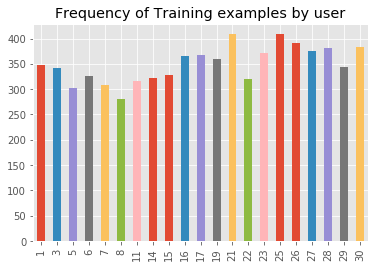

In [17]:
#Plotting the frequency of training data by user
plt.show(subjectTrain_df[0].value_counts().sort_index().plot(kind='bar', title='Frequency of Training examples by user'))

In [18]:
#adding fetaures as headers to xtrain
#xtrain_df.columns=feature561_df[1]
ytrain_df.columns=['Activity']
subjectTrain_df.columns=['User']

In [19]:
train_df=pd.concat([xtrain_df,ytrain_df,subjectTrain_df], axis=1)

In [20]:
#User-wise Activity frequency
pd.crosstab(train_df.User, train_df.Activity)

Activity,0,1,2,3,4,5
User,,,,,,
1,95,53,49,47,53,50
3,58,59,49,52,61,62
5,56,47,47,44,56,52
6,57,51,48,55,57,57
7,57,51,47,48,53,52
8,48,41,38,46,54,54
11,59,54,46,53,47,57
14,59,54,45,54,60,51
15,54,48,42,59,53,72


# Implementing Machine Learning Algorithms

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score # for evaluation
from sklearn.metrics import confusion_matrix

In [22]:
classifiers = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(7), # because there are 6 different labels
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(xtrain_df, ytrain_df)
    ypred = clf.predict(xtest_df)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(ypred, ytest_df))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Score
Model,
DecisionTreeClassifier,0.723108
KNeighborsClassifier,0.618935
SVC,0.769596
GaussianNB,0.724805
QuadraticDiscriminantAnalysis,0.484561


[Text(0,0,'DecisionTreeClassifier'),
 Text(0,0,'KNeighborsClassifier'),
 Text(0,0,'SVC'),
 Text(0,0,'GaussianNB'),
 Text(0,0,'QuadraticDiscriminantAnalysis')]

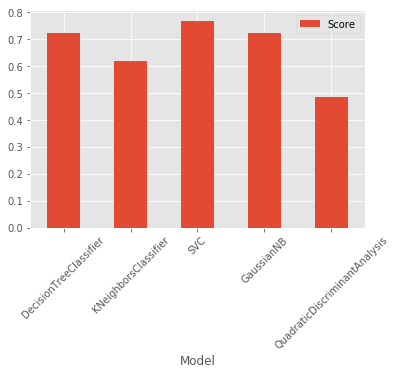

In [24]:
ax = score_df.plot.bar()
ax.set_xticklabels(score_df.index, rotation=45, fontsize=10)

In [25]:
svc_model_linear = SVC(kernel = 'linear', C = 1).fit(xtrain_df, ytrain_df)
svc_predictions = svc_model_linear.predict(xtest_df)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
# model accuracy for X_test  
accuracy = svc_model_linear.score(xtest_df, ytest_df)
accuracy

0.6077366813708857

In [27]:
# creating a confusion matrix
cm = confusion_matrix(ytest_df, svc_predictions)
cm

array([[179,  69,  97,  50, 101,   0],
       [104, 212,  49,  32,  74,   0],
       [135,  52, 118,  39,  76,   0],
       [  2,  25,   1, 370,  93,   0],
       [  2,  74,   6,  75, 375,   0],
       [  0,   0,   0,   0,   0, 537]], dtype=int64)

# Implementing Recurrent Neural Networks

In [28]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
'''history = model.fit_generator(,y_train,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=X_test,
                              validation_steps=val_steps)'''

'history = model.fit_generator(,y_train,\n                              steps_per_epoch=500,\n                              epochs=20,\n                              validation_data=X_test,\n                              validation_steps=val_steps)'

In [ ]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    callbacks=None,
                    #validation_split=0.2,
                    validation_data = (X_test, y_test),
                    #validation_data=None,
                    shuffle=True,
                    #class_weight=None, sample_weight=None,initial_epoch=0, steps_per_epoch=None, validation_steps=None
                   )

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 21s 3ms/step - loss: 1.8470 - acc: 0.1861 - val_loss: 1.2567 - val_acc: 0.2684
Epoch 2/50
7352/7352 [==============================] - 19s 3ms/step - loss: 1.0696 - acc: 0.3685 - val_loss: 1.0539 - val_acc: 0.3824
Epoch 3/50
7352/7352 [==============================] - 19s 3ms/step - loss: 0.9815 - acc: 0.4310 - val_loss: 1.0088 - val_acc: 0.4014
Epoch 4/50
5800/7352 [======================>.......] - ETA: 3s - loss: 0.9187 - acc: 0.4516

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

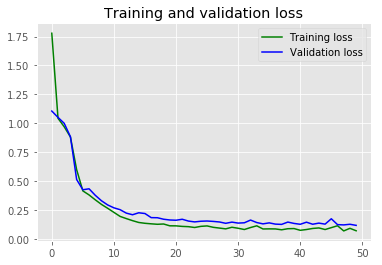

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

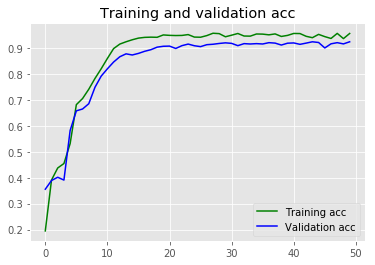

In [28]:
loss = history.history['acc']
val_loss = history.history['val_acc']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'g', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.show()